In [1]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt

In [10]:
# Hyperparameters
cuda = True
epochs = 10
log_interval = 400
batchSize = 16

lr = 0.001

In [38]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(3 * 32 * 32, 20)
        self.fc2 = nn.Linear(20, 10)

    def forward(self, x):
        x = x.view(-1, 3 * 32 * 32)
        activation_1 = F.relu(self.fc1(x))
        x = self.fc2(activation_1)
        return x, torch.sign(activation_1)
    
model = Net()
print(model)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

Net (
  (fc1): Linear (3072 -> 20)
  (fc2): Linear (20 -> 10)
)


In [44]:
class ActivationFollower():
    
    train_activations = {}
    test_activations = {}
    
    def __init__(self):
        self.train_activations = {}
        self.test_activations = {}
    
    def reset(self):
        train_activations = {}
        test_activations = {}
    
    def train_add(self, x):
        x.flags.writeable = False
        for i in range(x.shape[0]):
            self.train_activations[x[i].data] = self.train_activations.get(x[i].data, 0) + 1
    
    def test_add(self, x):
        x.flags.writeable = False
        for i in range(x.shape[0]):
            self.test_activations[x[i].data] = self.test_activations.get(x[i].data, 0) + 1
        
    def print_metrics(self):
        print("Unique Train Activation : {}, Unique Test activations : {}, Intersection : {}"
                  .format(len(self.train_activations.keys()), 
                          len(self.test_activations.keys()), 
                          len(set(self.train_activations.keys()).intersection(self.test_activations.keys()))
                )
            )
        plt.hist(self.train_activations.values(), label='Train Activations', log=True)
        plt.title('Histogram of activation patterns')
        plt.show()
        plt.hist(self.test_activations.values(), label='Test Activations', log=True)
        plt.title('Histogram of activation patterns')
        plt.show()
        

In [40]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batchSize,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batchSize,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [41]:
if cuda:
    model.cuda()
    criterion.cuda()

In [42]:
def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(trainloader):
        if cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output, activations = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(trainloader.dataset),
                100. * batch_idx / len(trainloader), loss.data[0]))

def test(epoch):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in testloader:
        if cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data, volatile=True), Variable(target)
        output, activations = model(data)
        test_loss += criterion(output, target).data[0]
        pred = output.data.max(1)[1] # get the index of the max log-probability
        correct += pred.eq(target.data).cpu().sum()

    test_loss = test_loss
    test_loss /= len(testloader) # loss function already averages over batch size
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(testloader.dataset),
        100. * correct / len(testloader.dataset)))
    
def activation_metrics():
    metrics = ActivationFollower()
    for batch_idx, (data, target) in enumerate(trainloader):
        if cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        output, activations = model(data)
        metrics.train_add(activations.cpu().data.numpy())
    for batch_idx, (data, target) in enumerate(testloader):
        if cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        output, activations = model(data)
        metrics.test_add(activations.cpu().data.numpy())
        
    metrics.print_metrics()
    return metrics

Train Epoch: 1 [0/50000 (0%)]	Loss: 1.500382
Train Epoch: 1 [6400/50000 (13%)]	Loss: 1.423061
Train Epoch: 1 [12800/50000 (26%)]	Loss: 1.318969
Train Epoch: 1 [19200/50000 (38%)]	Loss: 1.266513
Train Epoch: 1 [25600/50000 (51%)]	Loss: 1.495222
Train Epoch: 1 [32000/50000 (64%)]	Loss: 1.596815
Train Epoch: 1 [38400/50000 (77%)]	Loss: 1.489481
Train Epoch: 1 [44800/50000 (90%)]	Loss: 1.755218

Test set: Average loss: 1.4983, Accuracy: 4657/10000 (47%)

Unique Train Activation : 34271, Unique Test activations : 8836, Intersection : 3759


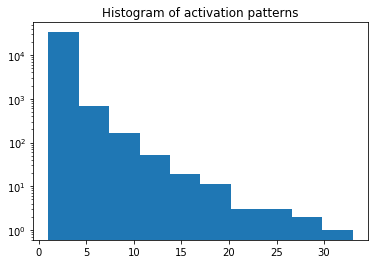

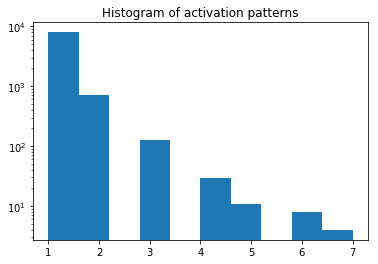

Train Epoch: 2 [0/50000 (0%)]	Loss: 1.313786
Train Epoch: 2 [6400/50000 (13%)]	Loss: 1.332062
Train Epoch: 2 [12800/50000 (26%)]	Loss: 0.769495
Train Epoch: 2 [19200/50000 (38%)]	Loss: 1.395926
Train Epoch: 2 [25600/50000 (51%)]	Loss: 1.787978
Train Epoch: 2 [32000/50000 (64%)]	Loss: 1.357047
Train Epoch: 2 [38400/50000 (77%)]	Loss: 1.155773
Train Epoch: 2 [44800/50000 (90%)]	Loss: 1.275785

Test set: Average loss: 1.5100, Accuracy: 4638/10000 (46%)

Unique Train Activation : 34076, Unique Test activations : 8861, Intersection : 3681


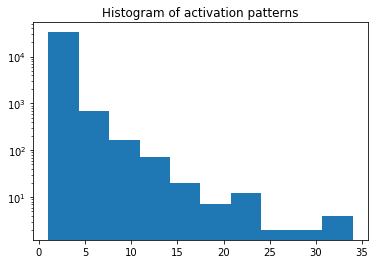

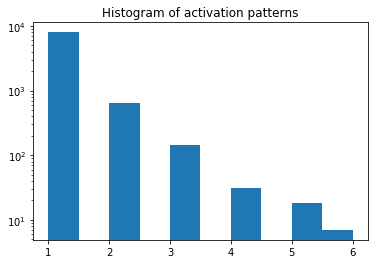

Train Epoch: 3 [0/50000 (0%)]	Loss: 1.437533
Train Epoch: 3 [6400/50000 (13%)]	Loss: 1.082450
Train Epoch: 3 [12800/50000 (26%)]	Loss: 1.137800
Train Epoch: 3 [19200/50000 (38%)]	Loss: 2.139344
Train Epoch: 3 [25600/50000 (51%)]	Loss: 1.644366
Train Epoch: 3 [32000/50000 (64%)]	Loss: 0.961581
Train Epoch: 3 [38400/50000 (77%)]	Loss: 1.416911
Train Epoch: 3 [44800/50000 (90%)]	Loss: 2.129764

Test set: Average loss: 1.5006, Accuracy: 4663/10000 (47%)

Unique Train Activation : 35293, Unique Test activations : 8986, Intersection : 3689


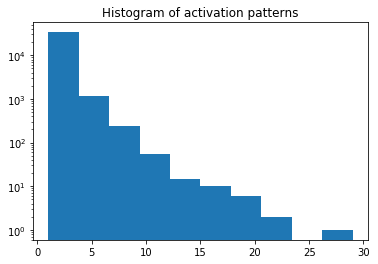

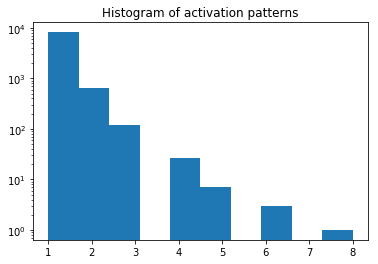

Train Epoch: 4 [0/50000 (0%)]	Loss: 1.116776
Train Epoch: 4 [6400/50000 (13%)]	Loss: 1.395666
Train Epoch: 4 [12800/50000 (26%)]	Loss: 1.095546
Train Epoch: 4 [19200/50000 (38%)]	Loss: 1.315610
Train Epoch: 4 [25600/50000 (51%)]	Loss: 1.637717
Train Epoch: 4 [32000/50000 (64%)]	Loss: 1.206032
Train Epoch: 4 [38400/50000 (77%)]	Loss: 1.165729
Train Epoch: 4 [44800/50000 (90%)]	Loss: 1.179396

Test set: Average loss: 1.5052, Accuracy: 4699/10000 (47%)

Unique Train Activation : 35778, Unique Test activations : 9043, Intersection : 3585


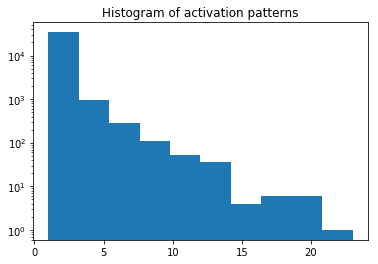

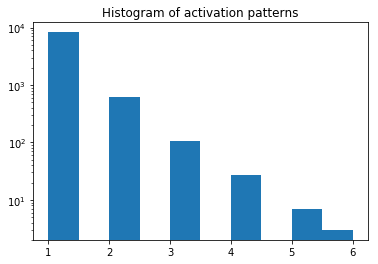

Train Epoch: 5 [0/50000 (0%)]	Loss: 1.086267
Train Epoch: 5 [6400/50000 (13%)]	Loss: 1.309980
Train Epoch: 5 [12800/50000 (26%)]	Loss: 1.431220
Train Epoch: 5 [19200/50000 (38%)]	Loss: 1.306190
Train Epoch: 5 [25600/50000 (51%)]	Loss: 1.485961
Train Epoch: 5 [32000/50000 (64%)]	Loss: 1.600667
Train Epoch: 5 [38400/50000 (77%)]	Loss: 1.734774
Train Epoch: 5 [44800/50000 (90%)]	Loss: 1.085904

Test set: Average loss: 1.5020, Accuracy: 4668/10000 (47%)

Unique Train Activation : 35506, Unique Test activations : 8999, Intersection : 3589


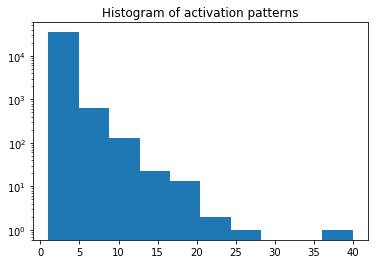

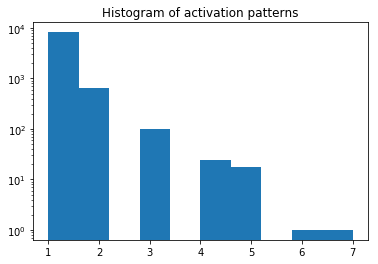

Train Epoch: 6 [0/50000 (0%)]	Loss: 1.550017
Train Epoch: 6 [6400/50000 (13%)]	Loss: 1.097331
Train Epoch: 6 [12800/50000 (26%)]	Loss: 1.355475
Train Epoch: 6 [19200/50000 (38%)]	Loss: 1.479139
Train Epoch: 6 [25600/50000 (51%)]	Loss: 1.418127
Train Epoch: 6 [32000/50000 (64%)]	Loss: 1.513797
Train Epoch: 6 [38400/50000 (77%)]	Loss: 1.413630
Train Epoch: 6 [44800/50000 (90%)]	Loss: 1.840717

Test set: Average loss: 1.5020, Accuracy: 4666/10000 (47%)

Unique Train Activation : 34998, Unique Test activations : 8913, Intersection : 3607


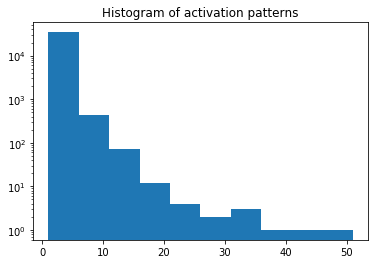

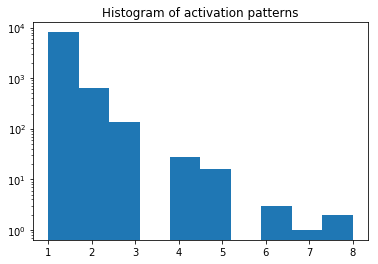

Train Epoch: 7 [0/50000 (0%)]	Loss: 1.101674
Train Epoch: 7 [6400/50000 (13%)]	Loss: 1.023818
Train Epoch: 7 [12800/50000 (26%)]	Loss: 1.483559
Train Epoch: 7 [19200/50000 (38%)]	Loss: 2.165099
Train Epoch: 7 [25600/50000 (51%)]	Loss: 1.122998
Train Epoch: 7 [32000/50000 (64%)]	Loss: 2.001039
Train Epoch: 7 [38400/50000 (77%)]	Loss: 1.248189
Train Epoch: 7 [44800/50000 (90%)]	Loss: 1.203545

Test set: Average loss: 1.4981, Accuracy: 4635/10000 (46%)

Unique Train Activation : 37029, Unique Test activations : 9191, Intersection : 3473


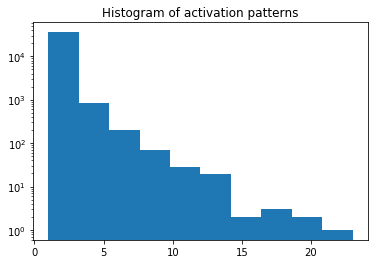

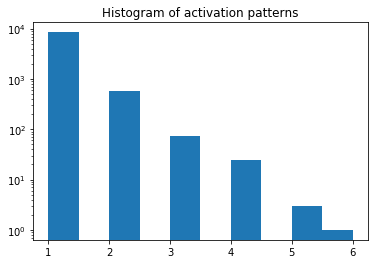

Train Epoch: 8 [0/50000 (0%)]	Loss: 1.080674
Train Epoch: 8 [6400/50000 (13%)]	Loss: 0.951443
Train Epoch: 8 [12800/50000 (26%)]	Loss: 1.586758
Train Epoch: 8 [19200/50000 (38%)]	Loss: 1.001272
Train Epoch: 8 [25600/50000 (51%)]	Loss: 0.995997
Train Epoch: 8 [32000/50000 (64%)]	Loss: 1.355008
Train Epoch: 8 [38400/50000 (77%)]	Loss: 1.337142
Train Epoch: 8 [44800/50000 (90%)]	Loss: 1.673157

Test set: Average loss: 1.4943, Accuracy: 4653/10000 (47%)



In [ ]:
for epoch in range(1, epochs + 1):
    train(epoch)
    test(epoch)
    activation_metrics()